In [2]:
import os
import re
import json
import logging
import tempfile
from zipfile import ZipFile
from itertools import islice
from urllib.parse import urlparse

import torch
import monai
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import requests
from datasets import load_dataset
from nibabel.processing import resample_to_output


In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Constants
CACHE_DIR = "./cached_lynos"
os.makedirs(CACHE_DIR, exist_ok=True)

def load_nii_from_zip(zip_url, file_path):
    """
    Download a ZIP file (if not already cached), extract the specified .nii.gz file,
    load it with nibabel into memory, and then delete the temporary file.
    """
    parsed_url = urlparse(zip_url)
    # Clean filename: remove query parameters and invalid characters
    clean_filename = os.path.basename(parsed_url.path.split("?")[0])
    clean_filename = re.sub(r'[^a-zA-Z0-9_.-]', '_', clean_filename)
    zip_filename = os.path.join(CACHE_DIR, clean_filename)
    
    # Download the ZIP file if not already cached
    if not os.path.exists(zip_filename):
        logging.info(f"Downloading {zip_url} ...")
        try:
            response = requests.get(zip_url, stream=True)
            response.raise_for_status()
            with open(zip_filename, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        except requests.RequestException as e:
            logging.error(f"Error downloading {zip_url}: {e}")
            raise

    # Extract the target .nii.gz file from the ZIP archive
    try:
        with ZipFile(zip_filename, "r") as archive:
            with archive.open(file_path) as nii_file:
                # Create a temporary file to save the extracted .nii.gz
                with tempfile.NamedTemporaryFile(delete=False, suffix=".nii.gz") as temp_nii:
                    temp_nii.write(nii_file.read())
                    temp_nii_path = temp_nii.name
    except Exception as e:
        logging.error(f"Error extracting {file_path} from {zip_filename}: {e}")
        raise

    try:
        # Load image and force load data into memory
        img = nib.load(temp_nii_path)
        img_data = img.get_fdata()  # load data into memory
        # Create a new image object from in-memory data (so it no longer depends on the temp file)
        img_in_memory = nib.Nifti1Image(img_data, img.affine, img.header)
    finally:
        # Clean up the temporary file
        os.remove(temp_nii_path)
    
    return img_in_memory


In [4]:
def visualize_slice(ct_data, lymph_data, azygos_data, slice_nr):
    """
    Plot the CT image along with the lymph nodes and azygos segmentations for a given slice.
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 12))
    ax[0].imshow(ct_data[..., slice_nr], cmap="gray")
    ax[0].set_title("CT")
    ax[0].axis("off")

    ax[1].imshow(lymph_data[..., slice_nr], cmap="jet", interpolation="none")
    ax[1].set_title("Lymph Nodes")
    ax[1].axis("off")

    ax[2].imshow(azygos_data[..., slice_nr], cmap="jet", interpolation="none")
    ax[2].set_title("Azygos")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


In [5]:
def main():
    # Log versions and CUDA info
    logging.info(f"PyTorch version: {torch.__version__}")
    logging.info(f"CUDA Available: {torch.cuda.is_available()}")
    logging.info(f"CUDA Version: {torch.version.cuda}")
    logging.info(f"MONAI Version: {monai.__version__}")

    # Load dataset in streaming mode
    dataset = load_dataset("andreped/LyNoS", trust_remote_code=True, streaming=True)
    logging.info(f"Available Splits: {list(dataset.keys())}")  # Expected: ['test']

    # For testing, take 5 samples and save metadata to CSV/JSON
    data_list = list(islice(dataset["test"], 5))
    df = pd.DataFrame(data_list)
    df.to_csv("lynos_test_samples.csv", index=False)
    logging.info("✅ Dataset saved as 'lynos_test_samples.csv'")
    with open("lynos_test_samples.json", "w") as f:
        json.dump(data_list, f, indent=4)
    logging.info("✅ Dataset saved as 'lynos_test_samples.json'")
    logging.info("First Sample:")
    logging.info(json.dumps(data_list[0], indent=4))

    # Get first patient sample
    patient_1 = next(iter(dataset["test"]))
    slice_nr = 205  # Define the slice number to visualize

    # Define the file paths within the ZIP archive for each modality
    file_paths = {
        "ct": "Benchmark/Pat1/pat1_data.nii.gz",
        "lymphnodes": "Benchmark/Pat1/pat1_labels_LymphNodes.nii.gz",
        "azygos": "Benchmark/Pat1/pat1_labels_Azygos.nii.gz",
    }

    # Load and resample the CT image (linear interpolation, order=1)
    zip_url_ct = patient_1["ct"].split("::")[-1]
    ct_image = load_nii_from_zip(zip_url_ct, file_paths["ct"])
    ct_image = resample_to_output(ct_image, order=1)
    ct_data = ct_image.get_fdata().astype("int32")
    logging.info(f"CT: {ct_data.shape}, {ct_data.dtype}")

    # Load and resample the lymph nodes segmentation (nearest-neighbor, order=0)
    zip_url_lymph = patient_1["lymphnodes"].split("::")[-1]
    lymph_image = load_nii_from_zip(zip_url_lymph, file_paths["lymphnodes"])
    lymph_image = resample_to_output(lymph_image, order=0)
    lymph_data = lymph_image.get_fdata().astype("uint8")
    logging.info(f"Lymph Nodes: {lymph_data.shape}, {lymph_data.dtype}")

    # Load and resample the azygos segmentation (nearest-neighbor, order=0)
    zip_url_azygos = patient_1["azygos"].split("::")[-1]
    azygos_image = load_nii_from_zip(zip_url_azygos, file_paths["azygos"])
    azygos_image = resample_to_output(azygos_image, order=0)
    azygos_data = azygos_image.get_fdata().astype("uint8")
    logging.info(f"Azygos: {azygos_data.shape}, {azygos_data.dtype}")

    # HU clip the CT data for better contrast
    ct_data[ct_data < -1024] = -1024
    ct_data[ct_data > 400] = 400

    # Print shapes and dtypes (optional)
    print("CT:", ct_data.shape, ct_data.dtype)
    print("Lymph Nodes:", lymph_data.shape, lymph_data.dtype)
    print("Azygos:", azygos_data.shape, azygos_data.dtype)

    # Visualize the chosen slice
    visualize_slice(ct_data, lymph_data, azygos_data, slice_nr)


2025-02-06 12:43:14,253 [INFO] PyTorch version: 2.5.1+cu121
2025-02-06 12:43:14,254 [INFO] CUDA Available: True
2025-02-06 12:43:14,255 [INFO] CUDA Version: 12.1
2025-02-06 12:43:14,255 [INFO] MONAI Version: 1.4.0
2025-02-06 12:43:14,888 [INFO] Available Splits: ['test']


data is downloaded to: zip://Benchmark::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1


2025-02-06 12:43:15,252 [INFO] ✅ Dataset saved as 'lynos_test_samples.csv'
2025-02-06 12:43:15,256 [INFO] ✅ Dataset saved as 'lynos_test_samples.json'
2025-02-06 12:43:15,257 [INFO] First Sample:
2025-02-06 12:43:15,258 [INFO] {
    "ct": "zip://Benchmark/Pat1/pat1_data.nii.gz::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1",
    "lymphnodes": "zip://Benchmark/Pat1/pat1_labels_LymphNodes.nii.gz::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1",
    "azygos": "zip://Benchmark/Pat1/pat1_labels_Azygos.nii.gz::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1",
    "brachiocephalicveins": "zip://Benchmark/Pat1/pat1_labels_BrachiocephalicVeins.nii.gz::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1",
    "esophagus": "zip://Benchmark/Pat1/pat1_labels_Esophagus.nii.gz::https://zenodo.org/records/10102261/files/LyNoS.zip?download=1",
    "subclaviancarotidarteries": "zip://Benchmark/Pat1/pat1_labels_SubCarArt.nii.gz::https://zenodo.or

CT: (381, 381, 415) int32
Lymph Nodes: (381, 381, 415) uint8
Azygos: (381, 381, 415) uint8


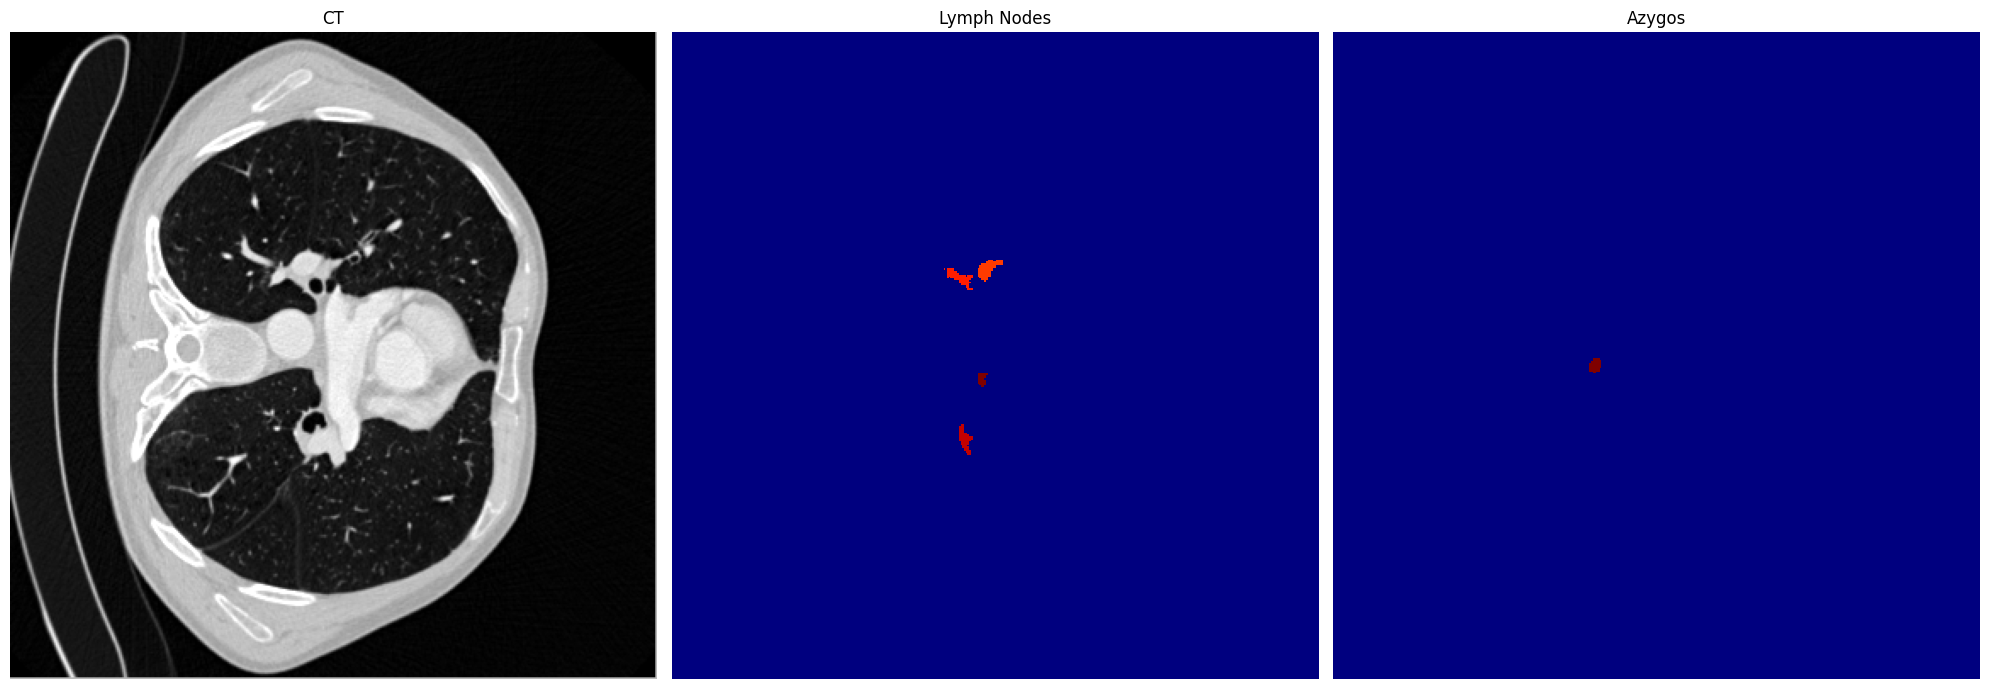

In [6]:

if __name__ == "__main__":
    main()

